## EG Starcraft Rank Prediction Model 
#### Joshua Liao


In [2]:
import os
import numpy as np
import pandas as pd
import pycaret as py
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

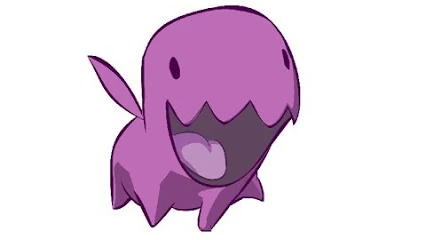

#### IMPORTING THE DATASET

In [12]:
scdf = pd.read_csv('starcraft_player_data.csv')

In [3]:
def set_pandas_display_options() -> None:
    display = pd.options.display
    display.max_columns = 1000
    display.max_rows = 4000
    display.max_colwidth = 199
    display.width = 1000

set_pandas_display_options()

In [4]:
display(scdf)

,GameID,LeagueIndex,Age,HoursPerWeek,TotalHours,APM,SelectByHotkeys,AssignToHotkeys,UniqueHotkeys,MinimapAttacks,MinimapRightClicks,NumberOfPACs,GapBetweenPACs,ActionLatency,ActionsInPAC,TotalMapExplored,WorkersMade,UniqueUnitsMade,ComplexUnitsMade,ComplexAbilitiesUsed
0,52,5,27,10,3000,143.71800,0.003515,0.000220,7,0.000110,0.000392,0.004849,32.6677,40.8673,4.7508,28,0.001397,6,0.000000,0.000000
1,55,5,23,10,5000,129.23220,0.003304,0.000259,4,0.000294,0.000432,0.004307,32.9194,42.3454,4.8434,22,0.001193,5,0.000000,0.000208
2,56,4,30,10,200,69.96120,0.001101,0.000336,4,0.000294,0.000461,0.002926,44.6475,75.3548,4.0430,22,0.000745,6,0.000000,0.000189
3,57,3,19,20,400,107.60160,0.001034,0.000213,1,0.000053,0.000543,0.003783,29.2203,53.7352,4.9155,19,0.000426,7,0.000000,0.000384
4,58,3,32,10,500,122.89080,0.001136,0.000327,2,0.000000,0.001329,0.002368,22.6885,62.0813,9.3740,15,0.001174,4,0.000000,0.000019
5,60,2,27,6,70,44.45700,0.000978,0.000255,2,0.000000,0.000000,0.002425,76.4405,98.7719,3.0965,16,0.000372,6,0.000000,0.000000
6,61,1,21,8,240,46.99620,0.000820,0.000169,6,0.000000,0.000045,0.001988,94.0227,90.5311,4.1017,15,0.000573,5,0.000000,0.000000
7,72,7,17,42,10000,212.60220,0.009040,0.000676,6,0.001164,0.001253,0.004952,24.6117,41.7671,6.6104,45,0.002277,9,0.000129,0.000249
8,77,4,20,14,2708,117.48840,0.002944,0.000527,2,0.000019,0.000414,0.005399,52.0140,46.4321,3.3746,29,0.001035,7,0.000273,0.000470
9,81,4,18,24,800,155.98560,0.005054,0.000524,8,0.000025,0.000399,0.003569,24.4632,52.1538,6.5664,27,0.001310,6,0.000000,0.000000


So here we read in the CSV file and begin to take a cursory look at the dataset.

#### CLEANING THE DATASET

So right off the bat, I see that there are missing values with '?'s. We get rid of those first as most Machine Learning functions don't take question marks as an input and replace them with NAN's. Since there aren't too many missing values, I decided to also drop the NAN's. I also change the data types of some numerical columns that are for some reason non-numeric data types.

In [13]:
scdf = scdf.replace('?', np.nan)
scdf=scdf.dropna()
scdf['LeagueIndex'].dtype
scdf['LeagueIndex'] = scdf['LeagueIndex'].astype('category')
scdf['Age'] = scdf['Age'].astype(float)
scdf['HoursPerWeek'] = scdf['HoursPerWeek'].astype(float)
scdf['TotalHours'] = scdf['TotalHours'].astype(float)


#### EXPLORATORY DATA ANALYSIS

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3338 entries, 0 to 3339
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   GameID                3338 non-null   int64   
 1   LeagueIndex           3338 non-null   category
 2   Age                   3338 non-null   float64 
 3   HoursPerWeek          3338 non-null   float64 
 4   TotalHours            3338 non-null   float64 
 5   APM                   3338 non-null   float64 
 6   SelectByHotkeys       3338 non-null   float64 
 7   AssignToHotkeys       3338 non-null   float64 
 8   UniqueHotkeys         3338 non-null   int64   
 9   MinimapAttacks        3338 non-null   float64 
 10  MinimapRightClicks    3338 non-null   float64 
 11  NumberOfPACs          3338 non-null   float64 
 12  GapBetweenPACs        3338 non-null   float64 
 13  ActionLatency         3338 non-null   float64 
 14  ActionsInPAC          3338 non-null   float64 
 15  Tota

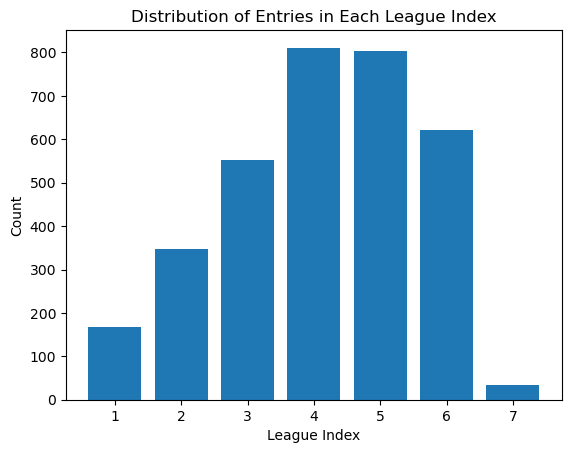

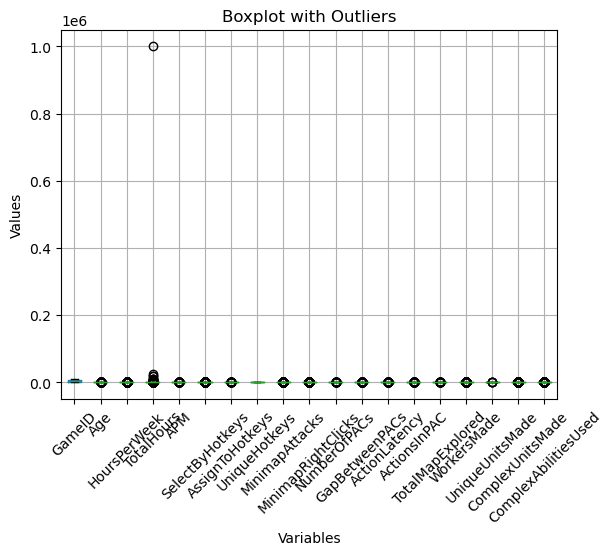

In [5]:
# Get information about the DataFrame
print(scdf.info())

# Summarize the statistics of the DataFrame
print(scdf.describe())

# View the column names
print(scdf.columns)

#Distribution of Ranks
league_counts = scdf['LeagueIndex'].value_counts().sort_index()

plt.bar(league_counts.index, league_counts.values)

plt.xlabel('League Index')
plt.ylabel('Count')
plt.title('Distribution of Entries in Each League Index')

fig, ax = plt.subplots()

# Create a boxplot for each variable in the DataFrame
scdf.boxplot(ax=ax)

# Set the title and labels
ax.set_title('Boxplot with Outliers')
ax.set_xlabel('Variables')
ax.set_ylabel('Values')

# Rotate x-axis labels if needed
plt.xticks(rotation=45)

# Show the plot
plt.show()

scdf = scdf[scdf['TotalHours'] <= 100000] 



We see through our boxplot that there is a significant outlier with total hours played. Looking through the dataset shows that one player has over 100,000 hours; which doesn't make much sense. This could be a data collection error? I definitely wish I could have spent that much time grinding in Valorant.

#### SPLITTING THE DATASET

So in order to start the process with feature selection, I need to split my dataset into training and testing set. 

In [14]:
X = scdf.drop('LeagueIndex', axis=1)
y = scdf['LeagueIndex']

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123) # We set the testing set to contain 20% of the original dataset, and we add random_state for reproducibility

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(2670, 19)
(668, 19)
(2670,)
(668,)


#### FEATURE SELECTION

Looking at the features I have, I intuitively know that 'GameID' has little to no impact on your rank as it is just a unique ID number for each game, so I drop it first.

In [16]:
scdf = scdf.drop(['GameID'], axis = 1)

One of the more common methods of finding variable importance is using a Random Forest model to determine feature importance. Here I apply Scikit Learn's Random Forest Model in order to determine importance, then I sorted it from highest to lowest.

GapBetweenPACs: 0.08933560296161831
TotalHours: 0.0784407377612779
APM: 0.0694870663041888
MinimapRightClicks: 0.06930775590187445
NumberOfPACs: 0.06802424700740288
HoursPerWeek: 0.06550510471333217
SelectByHotkeys: 0.06304884147582716
TotalMapExplored: 0.05593175426865997
UniqueHotkeys: 0.05258482949652996
MinimapAttacks: 0.05152031406130668
GameID: 0.05121050187748559
ActionLatency: 0.05029950186865808
ActionsInPAC: 0.042380502962111516
LeagueIndex: 0.039494124670231875
Age: 0.03850008615085486
AssignToHotkeys: 0.03437637475534733
ComplexUnitsMade: 0.032679067472089256
WorkersMade: 0.02829326392821116
UniqueUnitsMade: 0.019580322362992137


<Axes: >

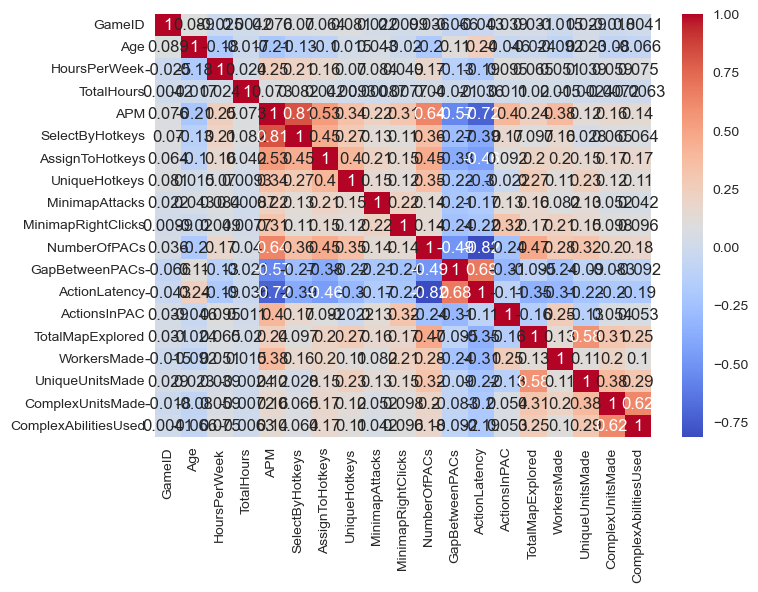

In [15]:
from sklearn.ensemble import RandomForestClassifier

# Assuming X_train and y_train are your training data
model = RandomForestClassifier()
model.fit(X_train, y_train)

#Feature importance
importances = model.feature_importances_

# Create a dictionary of feature names and importances
feature_importances = dict(zip(scdf.columns, importances))

# Sort feature importances in descending order
sorted_importances = sorted(feature_importances.items(), key=lambda x: x[1], reverse=True)

# Print feature importances in order of importance
for feature, importance in sorted_importances:
    print(f"{feature}: {importance}")

correlation_matrix = scdf.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')



Then I used a correlation matrix heat map to determine which variables were colinear and could be explained by other variables, and determined which variables to drop based off of that. 

In [17]:
scdf = scdf.drop(['ActionLatency','NumberOfPACs', 'WorkersMade','UniqueUnitsMade' ], axis=1)

##### MODEL SELECTION  

PyCaret runs an assortment of the most common models and compares their results. I used this to determine the best model from PyCaret's library of models.

In [18]:
from pycaret.classification import *
clf = setup(scdf, target='LeagueIndex', train_size=0.8, fold=5, normalize_method='zscore')

,Description,Value
0,Session id,1223
1,Target,LeagueIndex
2,Target type,Multiclass
3,Target mapping,"1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5, 7: 6"
4,Original data shape,"(3338, 15)"
5,Transformed data shape,"(3338, 15)"
6,Transformed train set shape,"(2670, 15)"
7,Transformed test set shape,"(668, 15)"
8,Numeric features,14
9,Preprocess,True


In [19]:
best_model = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.4019,0.7570,0.4019,0.3988,0.3967,0.2498,0.2506,0.4000
lr,Logistic Regression,0.3993,0.7505,0.3993,0.3969,0.3882,0.2427,0.2456,0.3760
et,Extra Trees Classifier,0.3869,0.7507,0.3869,0.3876,0.3820,0.2295,0.2305,0.3880
lda,Linear Discriminant Analysis,0.3865,0.7492,0.3865,0.3849,0.3777,0.2301,0.2329,0.2900
gbc,Gradient Boosting Classifier,0.3738,0.7479,0.3738,0.3715,0.3711,0.2187,0.2191,1.4840
lightgbm,Light Gradient Boosting Machine,0.3693,0.7433,0.3693,0.3664,0.3653,0.2109,0.2113,0.5240
ridge,Ridge Classifier,0.3625,0.0000,0.3625,0.3566,0.3253,0.1833,0.1915,0.2860
nb,Naive Bayes,0.3438,0.7224,0.3438,0.3320,0.2939,0.1952,0.2083,0.2840
knn,K Neighbors Classifier,0.3337,0.6604,0.3337,0.3369,0.3341,0.1735,0.1737,0.2900
dt,Decision Tree Classifier,0.3273,0.5828,0.3273,0.3285,0.3273,0.1664,0.1665,0.2880


Processing:   0%|          | 0/61 [00:00<?, ?it/s]

We see here that Random Forest Classifier seems to have done the best in terms of accuracy with the Logistic Regression model not being too far behind. However a 40% accuracy is quite low, so I want to see if I can tune it with PyCaret's built in tuner.

In [20]:
tuned_model = tune_model(best_model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.4045,0.7670,0.4045,0.4090,0.3996,0.2724,0.2747
1,0.3858,0.7587,0.3858,0.3869,0.3824,0.2481,0.2491
2,0.3876,0.7625,0.3876,0.3848,0.3810,0.2506,0.2519
3,0.3970,0.7599,0.3970,0.3937,0.3908,0.2594,0.2608
4,0.3764,0.7648,0.3764,0.3777,0.3686,0.2408,0.2431
Mean,0.3903,0.7626,0.3903,0.3904,0.3845,0.2543,0.2559
Std,0.0097,0.0030,0.0097,0.0106,0.0104,0.0109,0.0110


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


Tuning the model seems to have made it worse, so I stick with the original model.

In [21]:
evaluate_model(best_model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

Looking at the confusion Matrix we see that for the most part, our model predicts within one rank of the true rank. This can provide us valuable insight. Our model may be limited in the fact that the mechanical skill between certain ranks may not be as significantly different as we want them to be. 

In [128]:
from statsmodels.miscmodels.ordinal_model import OrderedModel

Originally looking at the dataset, I also wanted to try an Ordinal Logistic Model, as I thought it would fit well to this particular problem. I used statsmodels to fit an OLM to the data.

In [160]:
trainingscdf, testingscdf = train_test_split(scdf, test_size=0.2, random_state=123)

print("Training dataset shape:", trainingscdf.shape)
print("Testing dataset shape:", testingscdf.shape)

Training dataset shape: (2670, 20)
Testing dataset shape: (668, 20)


In [161]:
mod_log = OrderedModel(trainingscdf['LeagueIndex'],
                        trainingscdf[['Age', 'HoursPerWeek', 'TotalHours', 'APM', 'SelectByHotkeys', 'AssignToHotkeys', 'UniqueHotkeys', 'MinimapAttacks', 'MinimapRightClicks', 'GapBetweenPACs', 'ActionsInPAC', 'TotalMapExplored', 'ComplexUnitsMade', 'ComplexAbilitiesUsed']],
                        distr='logit')

res_log = mod_log.fit(method='bfgs', disp=False)
res_log.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OrderedModel Results                             
==============================================================================
Dep. Variable:            LeagueIndex   Log-Likelihood:                -3658.2
Model:                   OrderedModel   AIC:                             7360.
Method:            Maximum Likelihood   BIC:                             7490.
Date:                Thu, 25 May 2023                                         
Time:                        20:11:28                                         
No. Observations:                2670                                         
Df Residuals:                    2648                                         
Df Model:                          22                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Age                      0.0064      0.009      0.718      0.473      -0.011       0.024
HoursPerWeek             0.0098      0.004      2.725      0.006       0.003       0.017
TotalHours               0.0006   8.97e-05      6.908      0.000       0.000       0.001
APM                      0.0302      0.002     13.036      0.000       0.026       0.035
SelectByHotkeys        -82.1845     17.587     -4.673      0.000    -116.653     -47.716
AssignToHotkeys       1814.6262    226.846      7.999      0.000    1370.016    2259.237
UniqueHotkeys            0.0663      0.018      3.761      0.000       0.032       0.101
MinimapAttacks        1888.1478    272.507      6.929      0.000    1354.044    2422.252
MinimapRightClicks    -209.0570    113.103     -1.848      0.065    -430.735      12.621
GapBetweenPACs          -0.0315      0.003    -10.174      0.000      -0.038      -0.025
ActionsInPAC            -0.3186      0.032     -9.994      0.000      -0.381      -0.256
TotalMapExplored        -0.0033      0.007     -0.491      0.623      -0.016       0.010
WorkersMade            400.6122     78.797      5.084      0.000     246.173     555.051
UniqueUnitsMade         -0.0581      0.025     -2.336      0.019      -0.107      -0.009
ComplexUnitsMade       420.9012    443.358      0.949      0.342    -448.065    1289.868
ComplexAbilitiesUsed   177.8927    181.912      0.978      0.328    -178.648     534.434
1/2                     -2.4241      0.383     -6.321      0.000      -3.176      -1.672
2/3                      0.5252      0.056      9.429      0.000       0.416       0.634
3/4                      0.3317      0.044      7.592      0.000       0.246       0.417
4/5                      0.5034      0.035     14.223      0.000       0.434       0.573
5/6                      0.6313      0.036     17.454      0.000       0.560       0.702
6/7                      1.4648      0.053     27.847      0.000       1.362       1.568
========================================================================================
"""

In [167]:
predicted = res_log.model.predict(res_log.params, exog=testingscdf[['Age', 'HoursPerWeek', 'TotalHours', 'APM', 'SelectByHotkeys', 'AssignToHotkeys', 'UniqueHotkeys', 'MinimapAttacks', 'MinimapRightClicks', 'GapBetweenPACs', 'ActionsInPAC', 'TotalMapExplored', 'WorkersMade', 'UniqueUnitsMade', 'ComplexUnitsMade', 'ComplexAbilitiesUsed']])
print(np.round(predicted,2))

actual_choice = testingscdf['LeagueIndex'].values
print(actual_choice)

[[0.01 0.02 0.07 ... 0.42 0.2  0.  ]
 [0.11 0.3  0.33 ... 0.05 0.01 0.  ]
 [0.01 0.04 0.12 ... 0.36 0.12 0.  ]
 ...
 [0.   0.   0.   ... 0.1  0.79 0.09]
 [0.04 0.14 0.29 ... 0.15 0.03 0.  ]
 [0.   0.   0.   ... 0.11 0.79 0.08]]
[5, 1, 4, 5, 5, ..., 5, 3, 5, 4, 7]
Length: 668
Categories (7, int64): [1, 2, 3, 4, 5, 6, 7]


In [168]:
pred_choice = predicted.argmax(1)
actual_choice = testingscdf['LeagueIndex'].values
accuracy = (pred_choice == actual_choice).mean()
print('Fraction of correct choice predictions:', accuracy)


[4 2 4 5 3 2 4 3 2 3 3 3 2 5 4 5 4 2 1 4 3 3 4 2 3 4 1 5 3 2 2 2 4 4 2 1 3
 4 4 2 5 3 3 0 4 3 1 2 3 4 2 1 3 5 4 2 3 3 5 3 2 3 2 3 4 3 3 4 5 1 4 4 4 4
 5 5 4 4 3 3 3 4 2 3 4 5 3 3 3 2 4 3 3 1 3 2 3 3 3 3 3 4 4 0 3 5 3 3 4 3 1
 2 4 3 2 0 3 5 5 4 2 1 4 3 1 4 1 2 4 4 3 4 3 5 4 4 3 2 3 4 1 3 3 2 3 2 3 5
 3 3 0 4 4 3 3 2 1 3 3 4 3 3 2 0 5 5 4 1 5 5 5 4 4 5 3 5 3 4 5 3 5 1 1 4 3
 5 4 4 4 2 3 5 1 4 1 5 3 3 3 4 4 5 1 5 3 2 5 5 1 2 3 2 2 1 1 4 3 2 5 5 4 3
 3 3 2 4 3 4 5 3 4 5 3 2 2 2 5 2 5 5 3 1 3 3 3 4 1 3 3 2 1 3 3 3 3 2 4 4 3
 4 3 3 4 3 1 4 4 4 3 3 4 2 1 2 2 3 3 2 3 3 4 5 4 4 4 4 2 4 3 5 2 3 3 2 3 6
 3 4 5 4 4 2 3 3 5 4 2 4 5 4 3 3 2 4 1 4 5 3 5 5 4 3 5 1 2 4 3 4 4 4 4 3 2
 3 5 4 4 4 5 4 2 3 5 3 2 5 4 2 4 3 4 3 4 5 3 2 5 2 4 5 3 1 3 3 3 3 2 3 5 2
 2 4 5 5 3 4 1 4 3 0 3 3 5 3 3 2 1 3 5 2 5 3 4 3 4 4 3 5 3 4 1 2 5 4 3 5 4
 3 3 5 0 3 3 4 2 4 3 3 3 3 5 3 3 4 2 3 4 2 4 2 3 3 3 5 2 3 3 0 1 4 2 3 1 3
 4 3 1 3 2 2 3 2 3 2 4 5 4 4 1 1 2 4 4 3 3 3 5 3 5 4 3 5 3 3 4 5 2 1 2 4 3
 5 2 1 3 2 4 4 4 3 3 4 3 

In [173]:
from sklearn.metrics import confusion_matrix
confusion_mat = confusion_matrix(actual_choice, pred_choice)
display(confusion_mat)

array([[ 0,  0,  0,  0,  0,  0,  0,  0],
       [ 4, 15, 10,  3,  0,  0,  0,  0],
       [ 4, 18, 26, 12,  2,  0,  0,  0],
       [ 2, 17, 33, 52, 10,  2,  0,  0],
       [ 0,  6, 26, 86, 35,  3,  0,  0],
       [ 0,  1,  8, 49, 69, 36,  1,  0],
       [ 0,  0,  0, 13, 55, 64,  0,  0],
       [ 0,  0,  0,  0,  1,  5,  0,  0]], dtype=int64)

However, we see here that it does significantly worse than my best PyCaret model. So as a result I stick with the Random Forest Model.

### Conclusions

It seems as though the Random Forest model seems to yield the highest accuracy for rank prediction with a 40% accuracy. This is definitely a model that can be improved and refined, however it still offers better results than random guessing. We see that it normally predicts within one rank correctly, so maybe it would help to bucketize the categories to improve the accuracy.

Predicting Starcraft ranks can be a challenging task due to the complex nature of the game and the numerous factors that contribute to a player's performance. Here are some potential factors that could affect the accuracy of my rank prediction model:

Skill Variability: Starcraft is a highly skill-based game, and players can have varying levels of skill and expertise. It's possible that the factors I have considered in your model, such as hours played and APM, may not capture the full complexity of player skill. Additional features related to game strategy, decision-making, and experience may be necessary to improve accuracy.

Unaccounted Factors: There may be additional factors that contribute to a player's rank that are not included in my model. For example, factors like teamwork, adaptability, decision-making under pressure, and game knowledge could play a significant role in determining a player's success. Exploring additional features or alternative modeling approaches may help capture these factors.

Practically speaking, this model could be used to offer insight on to smurf accounts who play in ranks far from their own, as the model seems to be able to predict within one rank of the true rank. However, overall accuracy could be improved if the stakeholders can collect more relavent features that are nonmechanical such as game length or minerals and gas collected. The more features that we can get the more insights we are probably able to cain. 